In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from pathlib import Path
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
from tensorflow.keras.callbacks import EarlyStopping
import bert

In [2]:
ONEDRIVE_PATH = Path(r"C:\Users\gusta\Kidbrooke Advisory Ab\KidbrookeOneDrive - Gustaf Backman exjobb")

# Read the financial data 
fin_path = ONEDRIVE_PATH / "Input Data/stock_data.pkl"
fin_data = pd.read_pickle(fin_path)
fin_data = fin_data.loc['2006-10-19' : '2013-11-22']

news_path = ONEDRIVE_PATH / "Input Data/financial_headlines_20061020-20131119.pkl"
news_data = pd.DataFrame(pd.read_pickle(news_path))
news_data.set_index('date',inplace=True)

bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [3]:
news_dates = news_data.index.drop_duplicates()
fin_dates = fin_data.index.drop_duplicates

# Find the dates which are present in both the financial data and news data
valid_dates = []
for date in news_dates: 
    if date in fin_data.index: 
        valid_dates.append(date)
        
# Create targets for all 3 time series 
targets = pd.DataFrame(dtype='int8')
prev_vals = fin_data.iloc[0]
for i in range(len(valid_dates)): 
    y_temp = []
    # If the value has increased since yesterday, y = 1
    if prev_vals['1 YEAR'] < fin_data.iloc[i+1]['1 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['3 YEAR'] < fin_data.iloc[i+1]['3 YEAR']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
        
    if prev_vals['S&P'] < fin_data.iloc[i+1]['S&P']: 
        y_temp.append(1)
    else:
        y_temp.append(0)
    targets = targets.append({'1 YEAR':y_temp[0], '3 YEAR':y_temp[1], 'S&P':y_temp[2]}, ignore_index=True)
    prev_vals = fin_data.iloc[i+1]

In [6]:
# Concatenate the news for each day in the valid indices, i.e. the indices that are present in both 
# the financial data and the news data 
texts = []
for ind,date in enumerate(tqdm(valid_dates)): 
    temp_texts = ""
    for i,text in enumerate(news_data.loc[date]['title']): 
        if i < len(news_data.loc[date]['title']) - 1:
            if any(char in text[-2:] for char in ['!','?']):
                temp_texts += text + " "
            else:
                temp_texts += text + ". "
        else:
            if any(char in text[-2:] for char in ['!','?']):
                temp_texts += text + ""
            else:
                temp_texts += text + "."
    texts.append(temp_texts)
texts = np.asarray(texts)
print("Length of texts:",len(texts))
print("Length of targets:",len(targets))

100%|██████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:38<00:00, 47.91it/s]

Length of texts: 1846
Length of targets: 1846


In [7]:
sess = tf.Session()

bert_module =  hub.Module(bert_path)
tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                      tokenization_info["do_lower_case"],])
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case=do_lower_case)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
tokens = []
for titles in tqdm(texts):
    tokens.append(tokenizer.tokenize(titles.lower()))

100%|█████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:10<00:00, 178.05it/s]


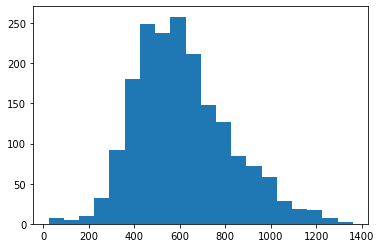

Ratio under 512: 0.3504875406283857


In [9]:
# Maximum sequence length is 512, check lengths on dataset
lengths = np.asarray([len(t) for t in tokens])
n = len(lengths)
plt.hist(lengths,20)
plt.show()
print("Ratio under 512:",sum(lengths < 512) / n)

In [10]:
max_length = 512

input_ids = np.zeros((n,max_length))
input_masks = np.zeros((n,max_length))
segment_ids = np.zeros((n,max_length))

for i in trange(n):
    tok = tokens[i]
    if len(tok) > max_length - 2:
        tok = tok[:max_length - 2]
    tok = ['[CLS]'] + tok + ['[SEP]']
    token_ids = tokenizer.convert_tokens_to_ids(tok)
    
    if len(token_ids) > max_length:
        token_ids = token_ids[:max_length]
        mask = [1] * max_length
    else: 
        mask = [1] * len(token_ids) + [0] * (max_length - len(token_ids))
        token_ids = token_ids + [0] * (max_length - len(token_ids))
    
    current_segment_id = 0
    segments = []
    for t in tok:
        segments.append(current_segment_id)
        if t == '[SEP]':
            current_segment_id = 1
    while len(segments) < max_length: 
        segments.append(0)
    assert len(token_ids) == max_length, "Wrong length of ids"
    assert len(segments) == max_length, "Wrong length of segments."
    assert len(mask) == max_length, "Wrong length of masks."
    
    input_ids[i] = np.asarray(token_ids)
    segment_ids[i] = segments
    input_masks[i] = mask

100%|████████████████████████████████████████████████████████████████████████████| 1846/1846 [00:00<00:00, 4667.87it/s]


In [11]:
zero_indices_1yr = np.where(targets['1 YEAR'] == 0)[0]
one_indices_1yr = np.where(targets['1 YEAR'] == 1)[0]

zero_indices_3yr = np.where(targets['3 YEAR'] == 0)[0]
one_indices_3yr = np.where(targets['3 YEAR'] == 1)[0]

zero_indices_sp = np.where(targets['S&P'] == 0)[0]
one_indices_sp = np.where(targets['S&P'] == 1)[0]

print(" ----- 1 YEAR RATE -----")
print("Ratio neg labels 1 year rate:",len(zero_indices_1yr) / len(targets))
print("Neg labels:", len(zero_indices_1yr), "Pos labels:",len(one_indices_1yr))
print(" ----- 3 YEAR RATE -----")
print("Ratio neg labels 3 year rate:",len(zero_indices_3yr) / len(targets))
print("Neg labels:", len(zero_indices_3yr), "Pos labels:",len(one_indices_3yr))
print(" -----     S&P     -----")
print("Ratio neg labels S&P:",len(zero_indices_sp) / len(targets))
print("Neg labels:", len(zero_indices_sp), "Pos labels:",len(one_indices_sp))

 ----- 1 YEAR RATE -----
Ratio neg labels 1 year rate: 0.6890574214517876
Neg labels: 1272 Pos labels: 574
 ----- 3 YEAR RATE -----
Ratio neg labels 3 year rate: 0.5937161430119177
Neg labels: 1096 Pos labels: 750
 -----     S&P     -----
Ratio neg labels S&P: 0.4637053087757313
Neg labels: 856 Pos labels: 990


In [12]:
n_train = 1200

np.random.shuffle(zero_indices_1yr)
np.random.shuffle(one_indices_1yr)
part_zeros_1yr = len(zero_indices_1yr) / n
train_indices_1yr = np.zeros((n_train),dtype=int)
train_indices_1yr[:round(part_zeros_1yr * n_train)] = zero_indices_1yr[:round(part_zeros_1yr * n_train)]
train_indices_1yr[round(part_zeros_1yr * n_train):] = one_indices_1yr[:round((1 - part_zeros_1yr) * n_train)]
np.random.shuffle(train_indices_1yr)
# All indices not in train is in test. 
test_indices_1yr = np.setdiff1d(np.arange(len(targets)), train_indices_1yr)
np.random.shuffle(test_indices_1yr)

np.random.shuffle(zero_indices_3yr)
np.random.shuffle(one_indices_3yr)
part_zeros_3yr = len(zero_indices_3yr) / n
train_indices_3yr = np.zeros((n_train),dtype=int)
train_indices_3yr[:round(part_zeros_3yr * n_train)] = zero_indices_3yr[:round(part_zeros_3yr * n_train)]
train_indices_3yr[round(part_zeros_3yr * n_train):] = one_indices_3yr[:round((1 - part_zeros_3yr) * n_train)]
np.random.shuffle(train_indices_3yr)
# All indices not in train is in test. 
test_indices_3yr = np.setdiff1d(np.arange(len(targets)), train_indices_3yr)
np.random.shuffle(test_indices_3yr)

np.random.shuffle(zero_indices_sp)
np.random.shuffle(one_indices_sp)
part_zeros_sp = len(zero_indices_sp) / n
train_indices_sp = np.zeros((n_train),dtype=int)
train_indices_sp[:round(part_zeros_sp * n_train)] = zero_indices_sp[:round(part_zeros_sp * n_train)]
train_indices_sp[round(part_zeros_sp * n_train):] = one_indices_sp[:round((1 - part_zeros_sp) * n_train)]
np.random.shuffle(train_indices_sp)
# All indices not in train is in test. 
test_indices_sp = np.setdiff1d(np.arange(len(targets)), train_indices_sp)
np.random.shuffle(test_indices_sp)

train_ids_1yr = input_ids[train_indices_1yr]
train_segs_1yr = segment_ids[train_indices_1yr]
train_masks_1yr = input_masks[train_indices_1yr]
y_train_1yr = targets.loc[train_indices_1yr]['1 YEAR'].values

test_ids_1yr = input_ids[test_indices_1yr]
test_segs_1yr = segment_ids[test_indices_1yr]
test_masks_1yr = input_masks[test_indices_1yr]
y_test_1yr = targets.loc[test_indices_1yr]['1 YEAR'].values

train_ids_3yr = input_ids[train_indices_3yr]
train_segs_3yr = segment_ids[train_indices_3yr]
train_masks_3yr = input_masks[train_indices_3yr]
y_train_3yr = targets.loc[train_indices_3yr]['3 YEAR'].values

test_ids_3yr = input_ids[test_indices_3yr]
test_segs_3yr = segment_ids[test_indices_3yr]
test_masks_3yr = input_masks[test_indices_3yr]
y_test_3yr = targets.loc[test_indices_3yr]['3 YEAR'].values

train_ids_sp = input_ids[train_indices_sp]
train_segs_sp = segment_ids[train_indices_sp]
train_masks_sp = input_masks[train_indices_sp]
y_train_sp = targets.loc[train_indices_sp]['S&P'].values

test_ids_sp = input_ids[test_indices_sp]
test_segs_sp = segment_ids[test_indices_sp]
test_masks_sp = input_masks[test_indices_sp]
y_test_sp = targets.loc[test_indices_sp]['S&P'].values

In [13]:
print(" ----- 1 YEAR RATE -----")
print("Train data label ratio (0 / 1):",np.sum(y_train_1yr == 0),"/", np.sum(y_train_1yr == 1))
print("Test data label ratio (0 / 1):",np.sum(y_test_1yr == 0),"/", np.sum(y_test_1yr == 1))

print(" ----- 3 YEAR RATE -----")
print("Train data label ratio (0 / 1):",np.sum(y_train_3yr == 0),"/", np.sum(y_train_3yr == 1))
print("Test data label ratio (0 / 1):",np.sum(y_test_3yr == 0),"/", np.sum(y_test_3yr == 1))
print(" -----     S&P     -----")
print("Train data label ratio (0 / 1):",np.sum(y_train_sp == 0),"/", np.sum(y_train_sp == 1))
print("Test data label ratio (0 / 1):",np.sum(y_test_sp == 0),"/", np.sum(y_test_sp == 1))

 ----- 1 YEAR RATE -----
Train data label ratio (0 / 1): 827 / 373
Test data label ratio (0 / 1): 445 / 201
 ----- 3 YEAR RATE -----
Train data label ratio (0 / 1): 712 / 488
Test data label ratio (0 / 1): 384 / 262
 -----     S&P     -----
Train data label ratio (0 / 1): 556 / 644
Test data label ratio (0 / 1): 300 / 346


In [14]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [15]:
def create_model(dense_nodes=256, dropout_rate=0.1, learning_rate=2e-5):
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    
    in_ids = keras.layers.Input(shape=(max_length,), dtype=tf.int32,name='input_id')
    in_mask = keras.layers.Input(shape=(max_length,),dtype=tf.int32,name='input_mask')
    in_seg = keras.layers.Input(shape=(max_length,),dtype=tf.int32, name='input_segment')

    bert_inputs = [in_ids, in_mask, in_seg]
    bert_output = BertLayer(n_fine_tune_layers=2,pooling='first')(bert_inputs)
    if dense_nodes == 0: 
        output_layer = keras.layers.Dense(1, activation='sigmoid')(bert_output)
        model = keras.models.Model(inputs=bert_inputs, outputs=output_layer)
        model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
        return model 
    dense_layer = keras.layers.Dense(dense_nodes, activation='relu')(bert_output)
    dropout_layer = keras.layers.Dropout(dropout_rate)(dense_layer)
    output_layer = keras.layers.Dense(1, activation='sigmoid')(dropout_layer)
    
    model = keras.models.Model(inputs=bert_inputs, outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
    return model

def init_sess(sess): 
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
    
def cont_training(model,x,y,epochs,history, validation_split=0.2): 
    temp_hist = model.fit(x,y,epochs=epochs,batch_size=32,validation_split=validation_split)
    for metric in history.history: 
        history.history[metric].append(temp_hist.history[metric][0])
    return history
    
def plot_results_nn(history, model,test_ids,test_masks, test_segs,y_test,save=False, name=''):
    plt.subplot(121)
    plt.plot(history.history['loss'],label='Loss')
    plt.plot(history.history['val_loss'],label='Val loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(history.history['acc'],label='Acc')
    plt.plot(history.history['val_acc'],label='Val acc')
    plt.legend()
    if save: 
        plt.savefig("Figs BERT/" + name + "history.jpg")
    plt.show() 
    y_test_pred = np.round(model.predict([test_ids, test_masks, test_segs]))
    plt.subplot(121)
    plt.bar([0,1],[np.sum(y_test == 0), np.sum(y_test == 1)], label='Actual test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.subplot(122)
    plt.bar([0,1],[np.sum(y_test_pred == 0), np.sum(y_test_pred == 1)], label='Pred test dist')
    plt.legend()
    plt.xticks([0, 1])
    plt.show()
    conf_mat = confusion_matrix(y_test,y_test_pred,normalize='pred')
    ax = sn.heatmap(conf_mat,)
    ax.set_ylabel("True values")
    ax.set_xlabel("Predicted values")
    if save: 
        plt.savefig("Figs BERT/" + name + "confmat.jpg")
    plt.show()
    print(classification_report(y_test, y_test_pred))
    print("Test accuracy:",round(np.sum(y_test == y_test_pred[:,0]) / len(y_test),3))

### Sigmoid layer on top

In [ ]:
model_1yr = create_model(dense_nodes=0)
init_sess(sess)
history_1yr = model_1yr.fit([train_ids_1yr, train_masks_1yr, train_segs_1yr], y_train_1yr,
                            validation_split=0.2,
                            epochs=1000,
                            batch_size=16,
                            callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 960 samples, validate on 240 samples
Epoch 1/1000
320/960 [=========>....................] - ETA: 10:13 - loss: 0.6387 - acc: 0.6938

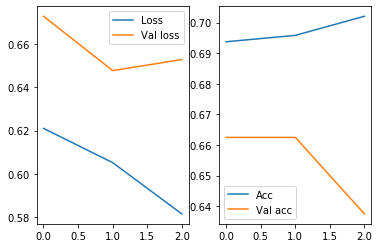

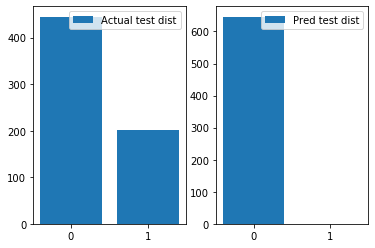

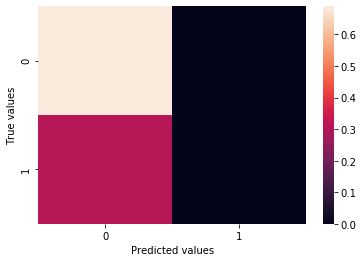

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.689


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
plot_results_nn(history_1yr, model_1yr, test_ids_1yr, test_masks_1yr, test_segs_1yr, 
                y_test_1yr,
                save=True,
                name='1yr_sigmoid')

In [81]:
model_3yr = create_model(dense_nodes=0)
init_sess(sess)
history_3yr = model_3yr.fit([train_ids_3yr, train_masks_3yr, train_segs_3yr], y_train_3yr, 
                            epochs=10000,
                            batch_size=32,
                            validation_split=0.2,
                            callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples, validate on 240 samples
Epoch 1/10000
960/960 [==============================] - 2523s 3s/sample - loss: 0.6868 - acc: 0.5760 - val_loss: 0.6829 - val_acc: 0.5333
Epoch 2/10000
960/960 [==============================] - 2356s 2s/sample - loss: 0.6803 - acc: 0.5781 - val_loss: 0.6686 - val_acc: 0.6250
Epoch 3/10000
960/960 [==============================] - 2404s 3s/sample - loss: 0.6705 - acc: 0.5854 - val_loss: 0.6654 - val_acc: 0.6292
Epoch 4/10000
960/960 [==============================] - 2383s 2s/sample - loss: 0.6658 - acc: 0.5854 - val_loss: 0.7213 - val_acc: 0.4875
Epoch 5/10000
960/960 [==============================] - 2374s 2s/sample - loss: 0.6549 - acc: 0.6208 - val_loss: 0.6743 - val_acc: 0.5750


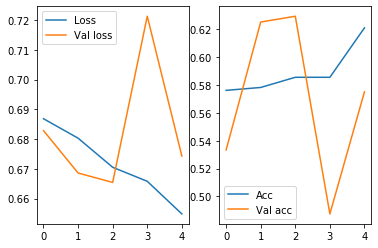

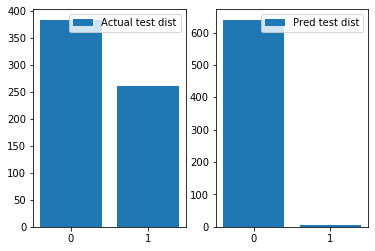

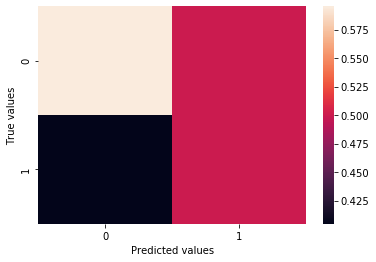

              precision    recall  f1-score   support

         0.0       0.60      0.99      0.74       384
         1.0       0.50      0.01      0.02       262

    accuracy                           0.59       646
   macro avg       0.55      0.50      0.38       646
weighted avg       0.56      0.59      0.45       646

Test accuracy: 0.594


In [82]:
plot_results_nn(history_3yr, model_3yr, test_ids_3yr, test_masks_3yr, test_segs_3yr, 
                y_test_3yr,
                save=True,
                name='3yr_sigmoid')

In [83]:
model_sp = create_model(dense_nodes=0) 
init_sess(sess)
history_sp = model_sp.fit([train_ids_sp, train_masks_sp, train_segs_sp], y_train_sp,
                          epochs=10000,1
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples, validate on 240 samples
Epoch 1/10000
960/960 [==============================] - 2832s 3s/sample - loss: 0.6954 - acc: 0.5167 - val_loss: 0.6966 - val_acc: 0.5167
Epoch 2/10000
960/960 [==============================] - 2660s 3s/sample - loss: 0.6842 - acc: 0.5656 - val_loss: 0.6910 - val_acc: 0.5250
Epoch 3/10000
960/960 [==============================] - 2564s 3s/sample - loss: 0.6789 - acc: 0.5729 - val_loss: 0.6988 - val_acc: 0.5375
Epoch 4/10000
960/960 [==============================] - 2617s 3s/sample - loss: 0.6776 - acc: 0.5990 - val_loss: 0.6923 - val_acc: 0.5375
Epoch 5/10000
960/960 [==============================] - 2871s 3s/sample - loss: 0.6459 - acc: 0.6375 - val_loss: 0.7023 - val_acc: 0.5417
Epoch 6/10000
960/960 [==============================] - 2798s 3s/sample - loss: 0.6315 - acc: 0.6490 - val_loss: 0.7004 - val_acc: 0.5417
Epoch 7/10000
960/960 [==============================] - 2607s 3s/sample - loss: 0.5272 - acc: 0.7635 - val_loss: 0.7796

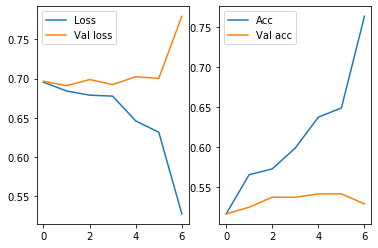

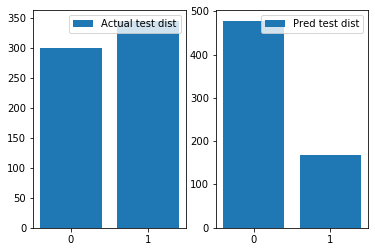

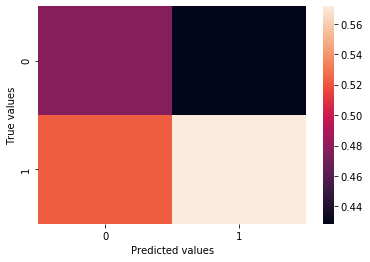

              precision    recall  f1-score   support

         0.0       0.48      0.76      0.59       300
         1.0       0.57      0.28      0.37       346

    accuracy                           0.50       646
   macro avg       0.52      0.52      0.48       646
weighted avg       0.53      0.50      0.47       646

Test accuracy: 0.502


In [84]:
plot_results_nn(history_sp, model_sp, test_ids_sp, test_masks_sp, test_segs_sp, 
                y_test_sp,
                save=True,
                name='sp_sigmoid')

### MLP on top
Same config for all models, dense nodes=256, dropout_rate = 0.1 and 2e-5 learning rate. 

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 2678s 3s/sample - loss: 0.6315 - acc: 0.6927 - val_loss: 0.6383 - val_acc: 0.6625
Epoch 2/1000
960/960 [==============================] - 2693s 3s/sample - loss: 0.6138 - acc: 0.6958 - val_loss: 0.6402 - val_acc: 0.6625
Epoch 3/1000
960/960 [==============================] - 2703s 3s/sample - loss: 0.6050 - acc: 0.7021 - val_loss: 0.6623 - val_acc: 0.6625


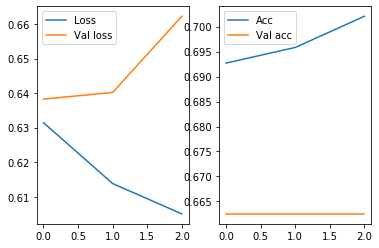

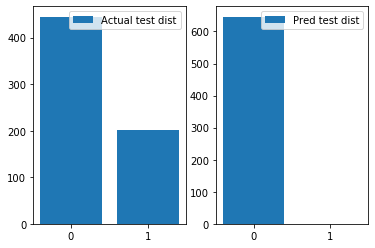

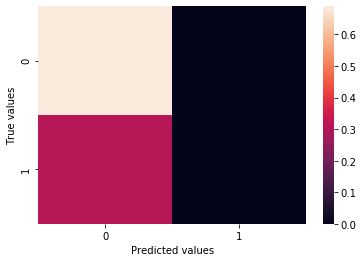

              precision    recall  f1-score   support

         0.0       0.69      1.00      0.82       445
         1.0       0.00      0.00      0.00       201

    accuracy                           0.69       646
   macro avg       0.34      0.50      0.41       646
weighted avg       0.47      0.69      0.56       646

Test accuracy: 0.689


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
model_1yr_mlp = create_model()
init_sess(sess)
history_1yr_mlp = model_1yr_mlp.fit([train_ids_1yr, train_masks_1yr, train_segs_1yr], y_train_1yr,
                            validation_split=0.2,
                            epochs=1000,
                            batch_size=16,
                            callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])

plot_results_nn(history_1yr_mlp, model_1yr_mlp, test_ids_1yr, test_masks_1yr, test_segs_1yr, 
                y_test_1yr,
                save=True,
                name='1yr_mlp')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 2991s 3s/sample - loss: 0.6887 - acc: 0.5729 - val_loss: 0.6665 - val_acc: 0.6250
Epoch 2/1000
960/960 [==============================] - 2938s 3s/sample - loss: 0.6758 - acc: 0.5875 - val_loss: 0.6629 - val_acc: 0.6250
Epoch 3/1000
960/960 [==============================] - 2988s 3s/sample - loss: 0.6653 - acc: 0.5958 - val_loss: 0.7059 - val_acc: 0.4917


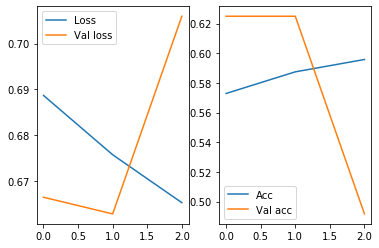

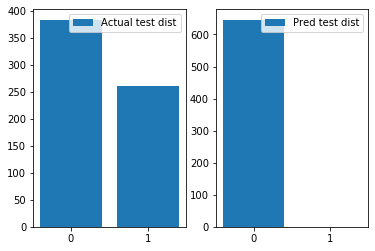

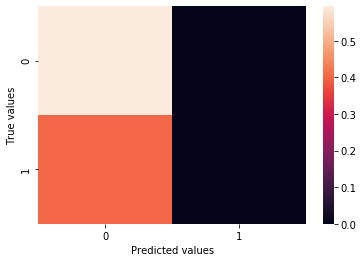

              precision    recall  f1-score   support

         0.0       0.59      1.00      0.75       384
         1.0       0.00      0.00      0.00       262

    accuracy                           0.59       646
   macro avg       0.30      0.50      0.37       646
weighted avg       0.35      0.59      0.44       646

Test accuracy: 0.594


C:\ProgramData\Anaconda3\envs\nlpenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
model_3yr_mlp = create_model(dense_nodes=0)
init_sess(sess)
history_3yr_mlp = model_3yr_mlp.fit([train_ids_3yr, train_masks_3yr, train_segs_3yr], y_train_3yr,
                            validation_split=0.2,
                            epochs=1000,
                            batch_size=16,
                            callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])

plot_results_nn(history_3yr_mlp, model_3yr_mlp, test_ids_3yr, test_masks_3yr, test_segs_3yr, 
                y_test_3yr,
                save=True,
                name='3yr_mlp')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 3245s 3s/sample - loss: 0.7011 - acc: 0.5219 - val_loss: 0.7013 - val_acc: 0.5167
Epoch 2/1000
960/960 [==============================] - 3207s 3s/sample - loss: 0.6848 - acc: 0.5479 - val_loss: 0.6940 - val_acc: 0.5208
Epoch 3/1000
960/960 [==============================] - 3235s 3s/sample - loss: 0.6713 - acc: 0.5813 - val_loss: 0.7084 - val_acc: 0.4917
Epoch 4/1000
960/960 [==============================] - 3248s 3s/sample - loss: 0.6689 - acc: 0.5771 - val_loss: 0.7336 - val_acc: 0.5292
Epoch 5/1000
960/960 [==============================] - 3241s 3s/sample - loss: 0.6069 - acc: 0.6750 - val_loss: 0.7324 - val_acc: 0.5125
Epoch 6/1000
960/960 [==============================] - 3259s 3s/sample - loss: 0.5054 - acc: 0.7656 - val_loss: 0.8268 - val_acc: 0.5292


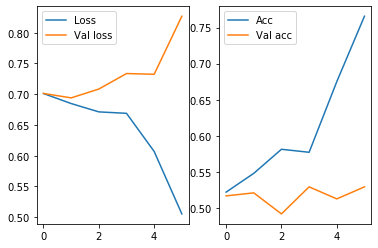

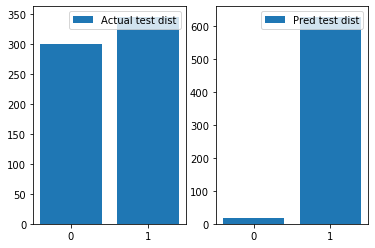

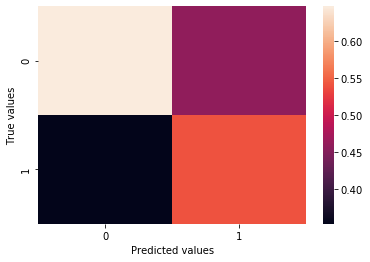

              precision    recall  f1-score   support

         0.0       0.65      0.04      0.07       300
         1.0       0.54      0.98      0.70       346

    accuracy                           0.54       646
   macro avg       0.59      0.51      0.38       646
weighted avg       0.59      0.54      0.41       646

Test accuracy: 0.543


In [87]:
model_sp_mlp = create_model(dense_nodes=0)
init_sess(sess)
history_sp_mlp = model_sp_mlp.fit([train_ids_sp, train_masks_sp, train_segs_sp], y_train_sp,
                            validation_split=0.2,
                            epochs=1000,
                            batch_size=16,
                            callbacks=[EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)])

plot_results_nn(history_sp_mlp, model_sp_mlp, test_ids_sp, test_masks_sp, test_segs_sp, 
                y_test_sp,
                save=True,
                name='sp_mlp')